In [1]:
import autograd.numpy as np  
from autograd import grad, elementwise_grad
from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
# First, we extract the data needed:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, sep=';')

X = data
print(X)
X = data.drop('quality', axis=1).values
y = data['quality'].values.astype(float)           # regression target

# Then, we preprocess the data so its ready for training:

x_train, x_test, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train_cls # One version for XGBoost, One for NN
y_test = y_test_cls

#Standarize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

#Reshape targets to (n_samples, 1)
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

placeholder_train = y_train
placeholder_test = y_test

print(y)
print(y.shape)
print(x_train.shape)
print(y_train.shape)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

XGBoost Regression MSE: 0.3503, R²: 0.5477


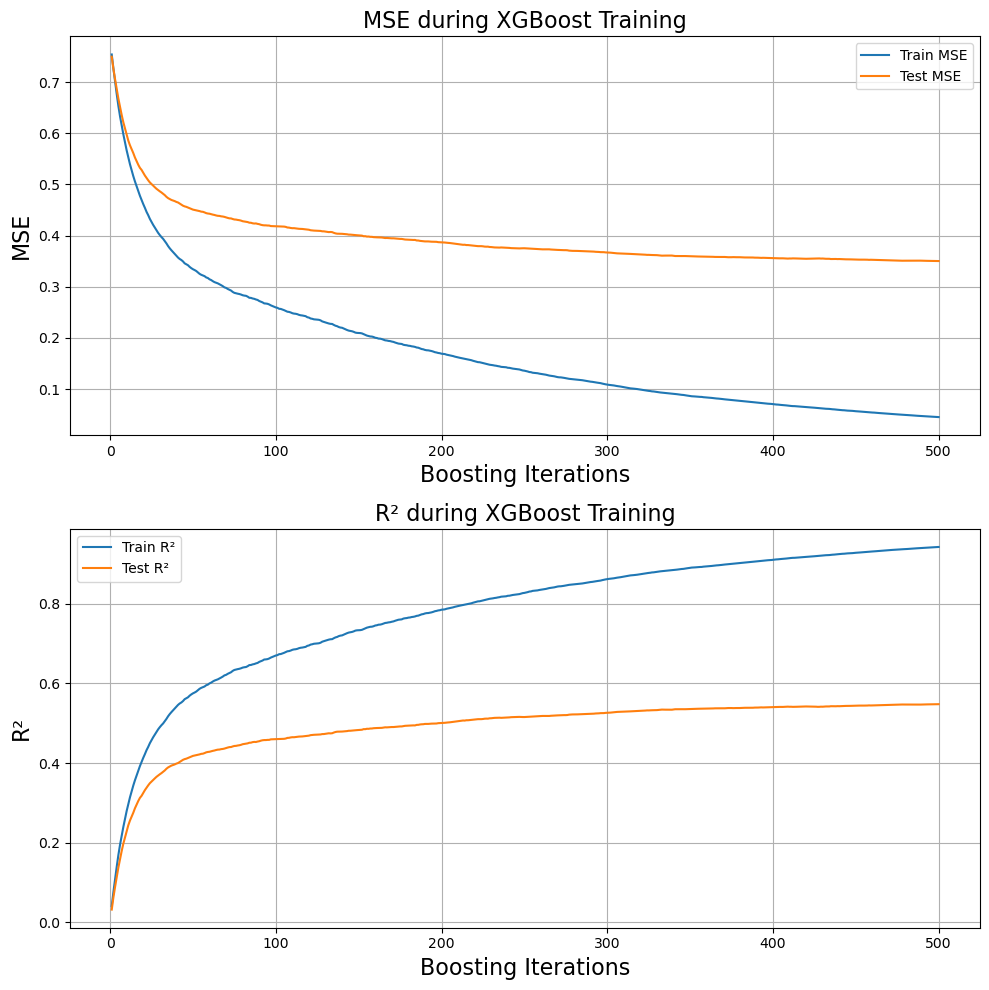

In [3]:
# Lets do reggression with XGBoost first

# I used this site for help
# https://xgboost.readthedocs.io/en/stable/get_started.html

import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

y_train = y_train_cls.copy() # Tree models work best with no reshape
y_test  = y_test_cls.copy()

# Your model setup (add eval_metric if you want more options)
xgbr = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    eval_metric=["rmse"] 
)

# Prepare evaluation sets
eval_set = [(x_train, y_train.ravel()), (x_test, y_test.ravel())]

# Fit with evaluation logging
xgbr.fit(
    x_train,
    y_train.ravel(),
    eval_set=eval_set,
    verbose=False 
)
pred = xgbr.predict(x_test)
print(f"XGBoost Regression MSE: {mean_squared_error(y_test, pred):.4f}, R²: {r2_score(y_test, pred):.4f}")

# Retrieve logged results
results = xgbr.evals_result()

# Extract RMSE for train and validation (test)
train_rmse = np.array(results['validation_0']['rmse'])
test_rmse = np.array(results['validation_1']['rmse'])

train_mse = train_rmse ** 2
test_mse = test_rmse ** 2

#Compute R2 for each iteration using staged predictions
# Precompute total sum of squares
y_train_mean = np.mean(y_train)
tss_train = np.sum((y_train - y_train_mean) ** 2)

y_test_mean = np.mean(y_test)
tss_test = np.sum((y_test - y_test_mean) ** 2)

#Get the booster readdy predictions
booster = xgbr.get_booster()
dtrain = xgb.DMatrix(x_train)
dtest = xgb.DMatrix(x_test)

num_iterations = len(train_rmse)
train_r2 = []
test_r2 = []

for i in range(1, num_iterations + 1):
    # Predict up to iteration i
    pred_train = booster.predict(dtrain, iteration_range=(0, i))
    rss_train = np.sum((y_train.ravel() - pred_train) ** 2)
    train_r2.append(1 - rss_train / tss_train)
    
    pred_test = booster.predict(dtest, iteration_range=(0, i))
    rss_test = np.sum((y_test.ravel() - pred_test) ** 2)
    test_r2.append(1 - rss_test / tss_test)


iterations = np.arange(1, num_iterations + 1)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# MSE plot
axs[0].plot(iterations, train_mse, label='Train MSE')
axs[0].plot(iterations, test_mse, label='Test MSE')
axs[0].set_xlabel('Boosting Iterations', fontsize = 16)
axs[0].set_ylabel('MSE', fontsize = 16)
axs[0].set_title('MSE during XGBoost Training', fontsize = 16)
axs[0].legend()
axs[0].grid(True)

# R² plot
axs[1].plot(iterations, train_r2, label='Train R²')
axs[1].plot(iterations, test_r2, label='Test R²')
axs[1].set_xlabel('Boosting Iterations', fontsize = 16)
axs[1].set_ylabel('R²', fontsize = 16)
axs[1].set_title('R² during XGBoost Training', fontsize = 16)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

y_train = placeholder_train
y_test  = placeholder_test

In [4]:
# We move over to the Neural Network

#Defining some activation functions and their derivative
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)
"""
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
"""
def sigmoid(z):
    return 1 / (1 + np.power(np.e, -1.0 * z))

def sigmoid_der(z):
    return sigmoid(z) * (1 - sigmoid(z))

def mse(predict, y_train):
    return np.mean((predict - y_train) ** 2)

def mse_der(predict, y_train):
    return 2 * (predict - y_train) / predict.shape[0]

In [5]:

# He initialization
def create_layers_batch(network_input_size, layer_output_sizes):
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        std = np.sqrt(2 / i_size) 
        W = np.random.randn(i_size, layer_output_size) * std  #Making sure the shapes macth
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

# Update forward/backprop for new W shape (x @ W)
def feed_forward_saver_batch(x, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = x
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a

def feed_forward(x, layers, activation_funcs):
    a = x
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a @ W + b
        a = activation_func(z)
    return a

#Computing gradients
def backpropagation_batch(x, layers, activation_funcs, y, activation_ders, cost_der=mse_der):
    layer_inputs, zs, predict = feed_forward_saver_batch(x, layers, activation_funcs)
    layer_grads = [() for _ in layers]
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]
        if i == len(layers) - 1:
            dC_da = cost_der(predict, y)
        else:
            (W_next, _) = layers[i + 1]
            dC_da = dC_dz @ W_next.T
        dC_dz = dC_da * activation_der(z)
        dC_dW = layer_input.T @ dC_dz
        dC_db = np.sum(dC_dz, axis=0)
        layer_grads[i] = (dC_dW, dC_db)
    return layer_grads


In [6]:

#Defining optimizers and their constants/ variables

def create_optimizer(optimizer_name="adam", lr=0.001):
    if optimizer_name == "sgd":
        return {"name": "sgd", "lr": lr}
    
    elif optimizer_name == "adam":
        return {
            "name": "adam",
            "lr": lr,
            "beta1": 0.9,
            "beta2": 0.999,
            "epsilon": 1e-8,
            "t": 0,
            "m": [],   #(m_W, m_b) for each layer
            "v": []    #(v_W, v_b) for each layer
        }
    
    elif optimizer_name == "rmsprop":
        return {
            "name": "rmsprop",
            "lr": lr,
            "beta": 0.99,
            "epsilon": 1e-8,
            "v": []
        }

def update_parameters(layers, grads, optimizer_config, t=None):
    
    #One function to rule them all!!
    #Pass in layers, gradients, and optimizer config, returns updated layers
    
    name = optimizer_config["name"]
    
    if name == "sgd":
        lr = optimizer_config["lr"]
        updated_layers = []
        for (W, b), (dW, db) in zip(layers, grads):
            W = W - lr * dW
            b = b - lr * db
            updated_layers.append((W, b))
        return updated_layers

    elif name == "adam":
        # Initialize m and v on first call
        if len(optimizer_config["m"]) == 0:
            optimizer_config["m"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
            optimizer_config["v"] = [(np.zeros_like(W), np.zeros_like(b)) for W, b in layers]
        
        beta1 = optimizer_config["beta1"]
        beta2 = optimizer_config["beta2"]
        lr = optimizer_config["lr"]
        eps = optimizer_config["epsilon"]
        t = optimizer_config["t"] + 1
        optimizer_config["t"] = t  # update timestep

        updated_layers = []
        for i, ((W, b), (dW, db)) in enumerate(zip(layers, grads)):
            m_W, m_b = optimizer_config["m"][i]
            v_W, v_b = optimizer_config["v"][i]

            #Adam update 
            m_W = beta1 * m_W + (1 - beta1) * dW
            m_b = beta1 * m_b + (1 - beta1) * db
            v_W = beta2 * v_W + (1 - beta2) * (dW ** 2)
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

            m_hat_W = m_W / (1 - beta1 ** t)
            m_hat_b = m_b / (1 - beta1 ** t)
            v_hat_W = v_W / (1 - beta2 ** t)
            v_hat_b = v_b / (1 - beta2 ** t)

            W = W - lr * m_hat_W / (np.sqrt(v_hat_W) + eps)
            b = b - lr * m_hat_b / (np.sqrt(v_hat_b) + eps)

            #Save
            optimizer_config["m"][i] = (m_W, m_b)
            optimizer_config["v"][i] = (v_W, v_b)
            updated_layers.append((W, b))

        return updated_layers

  

Epoch 1, Train MSE: 0.7537, Test MSE: 0.7399, R2: 0.0447
Epoch 2, Train MSE: 0.7129, Test MSE: 0.6968, R2: 0.1003
Epoch 3, Train MSE: 0.6674, Test MSE: 0.6540, R2: 0.1556
Epoch 4, Train MSE: 0.6269, Test MSE: 0.6156, R2: 0.2052
Epoch 5, Train MSE: 0.5960, Test MSE: 0.5911, R2: 0.2367
Epoch 6, Train MSE: 0.5760, Test MSE: 0.5727, R2: 0.2605
Epoch 7, Train MSE: 0.5663, Test MSE: 0.5669, R2: 0.2680
Epoch 8, Train MSE: 0.5620, Test MSE: 0.5632, R2: 0.2728
Epoch 9, Train MSE: 0.5590, Test MSE: 0.5621, R2: 0.2742
Epoch 10, Train MSE: 0.5730, Test MSE: 0.5728, R2: 0.2604
Epoch 11, Train MSE: 0.5556, Test MSE: 0.5608, R2: 0.2759
Epoch 12, Train MSE: 0.5585, Test MSE: 0.5605, R2: 0.2763
Epoch 13, Train MSE: 0.5872, Test MSE: 0.5862, R2: 0.2431
Epoch 14, Train MSE: 0.5484, Test MSE: 0.5535, R2: 0.2854
Epoch 15, Train MSE: 0.5469, Test MSE: 0.5538, R2: 0.2850
Epoch 16, Train MSE: 0.5509, Test MSE: 0.5540, R2: 0.2846
Epoch 17, Train MSE: 0.5430, Test MSE: 0.5511, R2: 0.2884
Epoch 18, Train MSE: 0.

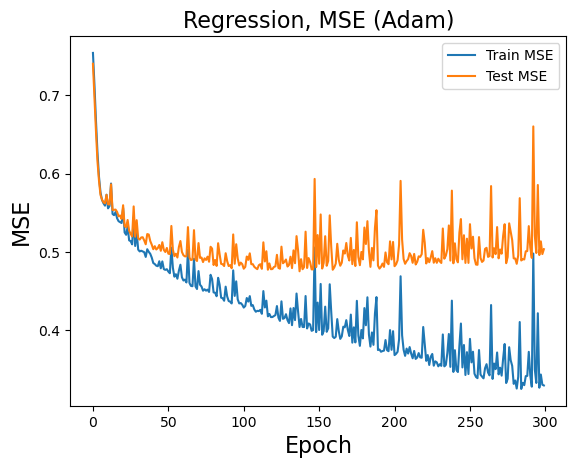

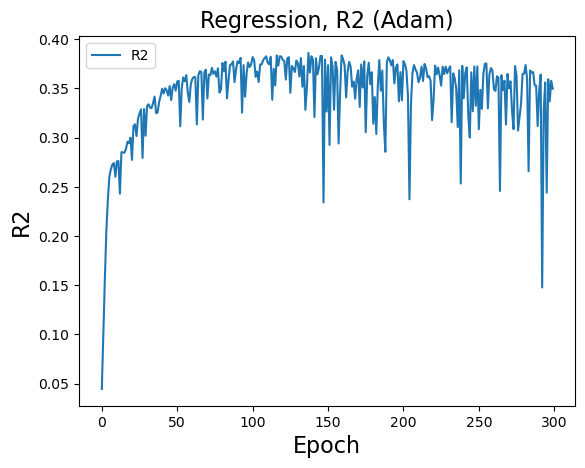

([(array([[-0.05177746,  0.71617694,  0.33892018, ...,  0.09073273,
           -0.08101701, -0.9337264 ],
          [ 0.17969806, -0.26977016,  0.32940841, ...,  0.36038902,
            0.10595973,  0.15919928],
          [ 0.21882769,  0.78702274, -1.10183575, ..., -0.91252996,
            0.22104168,  0.53149361],
          ...,
          [-0.05512905, -0.16723598,  0.30622548, ...,  0.44835364,
            1.2193199 , -1.17329271],
          [-0.55340588,  0.7071146 ,  0.30092377, ...,  0.38147482,
            0.07581261, -0.31830255],
          [-0.11920654,  0.40420465,  1.59139698, ...,  0.58553094,
           -0.46714416, -1.45739667]]),
   array([ 3.68371018e-01, -2.56267833e-01,  6.59075496e-01,  1.10152570e-01,
          -5.72634556e-01, -2.37071545e-01, -4.79110515e-01, -4.50292611e-01,
           8.40140131e-02,  3.12657820e-01, -5.46927814e-02,  4.13062472e-01,
          -3.22584923e-01,  2.76634685e-01, -9.19378822e-02, -1.43757785e-01,
           2.59687047e-02,  1.73453

In [7]:


#activation_funcs = [ReLU, ReLU, ReLU, ReLU, lambda x: x]  # ReLU hidden, linear output
#activation_ders = [ReLU_der, ReLU_der, ReLU_der, lambda x: np.ones_like(x)]

network_input_size = 11 # physicochemical features

activation_funcs = [sigmoid, sigmoid, sigmoid, lambda x: x]  
activation_ders = [sigmoid_der, sigmoid_der, sigmoid_der, lambda x: np.ones_like(x)]

layer_output_sizes = [128, 64, 32, 1]
learning_rate = 0.01
epochs = 300
train_batch_size = 100  # Add mini-batching

layers = create_layers_batch(network_input_size, layer_output_sizes)

def train_network(x_train, x_test, y_train, y_test, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size=18):
    train_MSE = []
    test_MSE = []
    R = []
    optimizer = create_optimizer("adam", lr=0.001)   #choosing optimizer. adam (lr = 0.001) or sgd (then lr=0.05)
    
    for epoch in range(epochs):
        # Shuffle
        perm = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[perm]
        y_shuffled = y_train[perm]
        
        # Mini-batch loop
        for start in range(0, x_train.shape[0], batch_size):
            end = min(start + batch_size, x_train.shape[0])
            input_batch = x_shuffled[start:end]
            target_batch = y_shuffled[start:end]
            
            layers_grad = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, cost_der=mse_der)
            layers = update_parameters(layers, layers_grad, optimizer)   #use optimizer
            
            for (W, b), (W_g, b_g) in zip(layers, layers_grad):
                W -= learning_rate * W_g
                b -= learning_rate * b_g
        
        #Computing accuracies and predictions
        train_pred = feed_forward(x_train, layers, activation_funcs)
        test_pred = feed_forward(x_test, layers, activation_funcs)
        train_mse = mse(train_pred, y_train)
        test_mse = mse(test_pred, y_test)
        train_MSE.append(train_mse) 
        test_MSE.append(test_mse)
        r2 = 1 - test_mse / np.var(y_test)
        R.append(r2)
        print(f"Epoch {epoch+1}, Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, R2: {r2:.4f}") #Inspect while training

        
    # Plot MSE
    plt.plot(train_MSE, label='Train MSE')
    plt.plot(test_MSE, label='Test MSE')
    plt.title('Regression, MSE (Adam)', fontsize = 16)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('MSE', fontsize = 16)
    plt.legend()
    plt.show()
    
    # Plot R2
    plt.plot(R, label='R2')
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('R2', fontsize = 16)
    plt.title('Regression, R2 (Adam)', fontsize = 16)
    plt.legend()
    plt.show()
    
    return layers, train_MSE, test_MSE

train_network(x_train, x_test, y_train, y_test, layers, activation_funcs, activation_ders, learning_rate, epochs, train_batch_size)